# Advanced PDF Retrieval & Optimization with LlamaIndex

This notebook builds on our previous exploration of embeddings and chunking to demonstrate advanced retrieval techniques using PDF documents. We'll explore query expansion, hybrid retrieval, and reranking to optimize the quality of search results.

## Section 1: Loading PDFs with PyMuPDF & LlamaIndex

### Why are we switching to PDFs?
- Most real-world document search tasks involve PDFs, not plain text
- Using PyMuPDF allows for better text extraction with preserved structure
- Working with PDFs introduces real-world challenges in document processing

### Installation

In [ ]:
# Install required libraries
!pip install -q llama-index llama-index-llms-gemini pymupdf
!pip install -q llama-index-embeddings-huggingface
!pip install nest_asyncio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 109.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.3/303.3 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 69.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.5/322.5 kB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.4/144.4 kB 12.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the sou

### Setting up the environment

In [ ]:
import os
import fitz  # PyMuPDF
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
import nest_asyncio

nest_asyncio.apply()

# Set up Google API key for Gemini
GOOGLE_API_KEY = ""  # Replace with your actual API key
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

# Create a directory for our PDFs if it doesn't exist
!mkdir -p sample_docs

### Loading and Exploring PDF Documents

First, let's see how to load and extract text from a PDF using PyMuPDF:

In [ ]:
from google.colab import files
import os

def upload_pdf():
    """Upload a PDF file and return its path."""
    print("Please select a PDF file to upload:")
    uploaded = files.upload()

    for filename in uploaded.keys():
        if filename.endswith('.pdf'):
            # Save to the sample_docs directory
            pdf_path = os.path.join("sample_docs", filename)

            # Create directory if it doesn't exist
            os.makedirs("sample_docs", exist_ok=True)

            # Save the file
            with open(pdf_path, 'wb') as f:
                f.write(uploaded[filename])

            print(f"PDF saved to {pdf_path}")
            return pdf_path
        else:
            print(f"File {filename} is not a PDF. Please upload a PDF file.")

    return None

Here you should upload a digital pdf (PDF where you can select some text). If you don't have a PDF, you can download this [sample pdf](https://drive.google.com/file/d/1jPMktO4uODm07z5smBPNGvTdxw868Kz8/view?usp=sharing) and then upload it.

In [ ]:
# Uncomment to upload your own PDF
pdf_path = upload_pdf()

Please select a PDF file to upload:


Saving sample_contract.pdf to sample_contract.pdf
PDF saved to sample_docs/sample_contract.pdf


In [ ]:
#  Uncomment if you would like to add your own path
# pdf_path = "/content/sample_docs/sample_contract.pdf"

In [ ]:
def extract_text_from_pdf(pdf_path):
    """Extract text from a PDF file using PyMuPDF."""
    doc = fitz.open(pdf_path)

    # Extract text from all pages
    text = "\n".join([page.get_text() for page in doc])

    # Print some stats
    print(f"PDF: {pdf_path}")
    print(f"Number of pages: {len(doc)}")
    print(f"Extracted {len(text.split())} words from the PDF.")

    # Close the document
    doc.close()

    return text

In [ ]:
# Example usage (after uploading a PDF):
if pdf_path:
    text = extract_text_from_pdf(pdf_path)
    print(text[:500])  # Print first 500 characters

PDF: sample_docs/sample_contract.pdf
Number of pages: 2
Extracted 315 words from the PDF.
SERVICE AGREEMENT CONTRACT
This Service Agreement (the "Agreement") is entered into as of January 15, 2025 (the "Effective Date")
by and between:
ABC Company Inc., with its principal place of business at 123 Business Avenue, Corporate City, State
12345 ("Service Provider"); and
XYZ Corporation, with its principal place of business at 456 Commerce Street, Enterprise Town, State
67890 ("Client").
1. SERVICES
1.1 Service Provider agrees to provide Client with consulting services ("Services") as des




### Section 1: Integrating PyMuPDF with LlamaIndex

Now let's set up a custom loader to integrate PyMuPDF with LlamaIndex:

In [ ]:
from llama_index.core import Document
from typing import List

def load_pdf_with_pymupdf(pdf_path: str) -> List[Document]:
    """Load a PDF and convert it to LlamaIndex Document format using PyMuPDF."""
    # Open the PDF
    doc = fitz.open(pdf_path)

    # Extract text from each page
    documents = []

    for i, page in enumerate(doc):
        text = page.get_text()

        # Skip empty pages
        if not text.strip():
            continue

        # Create Document object with metadata
        documents.append(
            Document(
                text=text,
                metadata={
                    "file_name": os.path.basename(pdf_path),
                    "page_number": i + 1,
                    "total_pages": len(doc)
                }
            )
        )

    # Close the document
    doc.close()

    # Print stats
    print(f"Processed {pdf_path}:")
    print(f"Extracted {len(documents)} pages with content")

    return documents

In [ ]:
# Example usage:
pdf_docs = load_pdf_with_pymupdf(pdf_path)

Processed sample_docs/sample_contract.pdf:
Extracted 2 pages with content


## Section 2: Indexing and Processing PDFs

Let's create the indexing infrastructure first:

In [ ]:
from llama_index.llms.gemini import Gemini
from llama_index.core import Settings
from llama_index.core import VectorStoreIndex
from llama_index.embeddings.huggingface import HuggingFaceEmbedding

# Initialize Gemini LLM
llm = Gemini(model="models/gemini-1.5-flash")
Settings.llm = llm

# Initialize embedding model
embed_model = HuggingFaceEmbedding(model_name="sentence-transformers/all-MiniLM-L6-v2")
Settings.embed_model = embed_model

def process_and_index_pdf(pdf_path):
    """Process a PDF and create both vector and keyword indices."""
    # Load documents
    documents = load_pdf_with_pymupdf(pdf_path)

    # Create vector index
    vector_index = VectorStoreIndex.from_documents(documents)

    print(f"Indexed {len(documents)} document chunks")

    return vector_index

/tmp/ipython-input-1633575060.py:7: DeprecationWarning: Call to deprecated class Gemini. (Should use `llama-index-llms-google-genai` instead, using Google's latest unified SDK. See: https://docs.llamaindex.ai/en/stable/examples/llm/google_genai/)
  llm = Gemini(model="models/gemini-1.5-flash")
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# Step 2: Index the PDF
index = process_and_index_pdf(pdf_path)

Processed sample_docs/sample_contract.pdf:
Extracted 2 pages with content
Indexed 2 document chunks


## Section 2: Implement Query Expansion & Rewriting

Query expansion helps improve retrieval by adding relevant terms to the original query.

In [ ]:
from llama_index.llms.gemini import Gemini
from llama_index.core import Settings

# Initialize Gemini LLM
llm = Gemini(model="models/gemini-1.5-flash")
Settings.llm = llm

# Simple query expansion function using Gemini
# Tells Gemini: “Here’s my query. Please create X variations using synonyms, legal terms, and rephrased versions.”
# Instructs the model to return only a list of alternative queries (no extra sentences).
def expand_query(query: str, num_expansions: int = 3) -> list:
    """Expand a query to include related terms using Gemini."""
    prompt = f"""
    I need to search a legal contract with this query: "{query}"

    Please help me expand this query by generating {num_expansions} alternative versions that:
    1. Use different but related terminology
    2. Include relevant legal terms that might appear in a contract
    3. Cover similar concepts but phrased differently

    Format your response as a list of alternative queries only, with no additional text.
    """

    # Asks Gemini to generate the expansions.
    # Example input: "termination of agreement"
    # Example output might be:
    # - Termination clause enforcement
    # - Contract cancellation provisions
    # - Agreement dissolution terms
    response = llm.complete(prompt)

    # Extract the expanded queries
    # Splits the text by line breaks.
    # Removes empty lines or whitespace.
    # Returns a clean Python list.
    expanded_queries = [line.strip() for line in response.text.split('\n') if line.strip()]

    # Add the original query if needed
    if query not in expanded_queries:
        expanded_queries = [query] + expanded_queries

    return expanded_queries

/tmp/ipython-input-4224461756.py:5: DeprecationWarning: Call to deprecated class Gemini. (Should use `llama-index-llms-google-genai` instead, using Google's latest unified SDK. See: https://docs.llamaindex.ai/en/stable/examples/llm/google_genai/)
  llm = Gemini(model="models/gemini-1.5-flash")


In [ ]:
# Example usage:
expanded = expand_query("What are the penalties for late payments?")
for i, q in enumerate(expanded):
    print(f"{i+1}. {q}")

1. What are the penalties for late payments?
2. * What are the consequences of delayed payment?
3. * What remedies are available to the obligee in the event of a breach of the payment terms?
4. *  What are the late payment fees, interest charges, or other sanctions for non-timely payment obligations?


## Creating a Query Expansion Engine

Now let's implement a more structured query expansion using LlamaIndex's built-in functionality:

## NOTE: This query-expansion method (code given below) using LlamaIndex is PREFERRABLE compared to the Google Gemini model as it improves performance. But, both LlamaIndex and Gemini will produce equivalent outputs.

## ✅ What it’s doing:

1. Start with a normal search tool: It builds a retriever that can find the top 2 most relevant text chunks when you ask a question.

2. Make the question bigger:
  - Instead of searching with just your one question, it asks the LLM to rewrite your question in 3 different ways.
  - Example: if your question was “What are the payment terms?”, Gemini might expand it to:
    - “How does the client pay the service provider?”
    - “What is the invoice and due date policy?”
    - “What are the agreed terms for payments?”

3. Search with all versions: It runs all those versions of the question through the retriever, collecting results from each one.

  - Imagine you have 3 versions of your question (original + 2 rewrites).
  - Instead of only searching with the original, the system runs all 3 questions separately in your document collection.
  - So you’re basically asking the same thing in different ways, and pulling back all the answers that match any of them.

Example: <br>
  - Original: “What are the payment terms?”
  - Rewrite 1: “How long does the client have to pay invoices?”
  - Rewrite 2: “When is payment due after invoicing?”

Each one is used to search the text, so you don’t miss important details.

4. Combine and reorder results: It mixes together the results, then re-ranks them so that the most consistent answers across all versions of the question rise to the top.

- Now you’ve got a pile of answers from those different searches.
- Some might overlap, some might be less relevant.
- The system merges them together, removes duplicates, and then reorders them so the best answers float to the top.
- “Best” is based on how consistently that passage showed up across the different versions of your query.

👉 Think of it like combining search results from Google, Bing, and Yahoo — then picking the most common, strongest ones.

5. Final query engine: Returns a query engine that you can ask questions to, and it will automatically expand your question, search multiple ways, and give you the best combined answer.

- Instead of you having to do all this manually (rewrite → search 3 times → merge results), the code wraps it all in a query engine.
- That means you can now just ask: “What are the payment terms?”
- Behind the scenes, it will:
    - Rewrite your question,
    - Search multiple ways,
    - Merge and reorder,
    - Pass the best matches to LLM for the final answer.

✅ In short:
This code takes your question, rewrites it in different ways, searches with all of them, and then blends the results so you get a stronger, more accurate answer.

In [ ]:
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core.retrievers import QueryFusionRetriever

# Function to create a query engine that uses query expansion
def create_query_expansion_engine(index):
    """Create a query engine that uses query expansion."""
    # First create multiple retrievers (base retriever)
    base_retriever = index.as_retriever(similarity_top_k=2)

    # Create a query fusion retriever
    fusion_retriever = QueryFusionRetriever(
        retrievers=[base_retriever],
        llm=llm,
        similarity_top_k=2,
        num_queries=3,  # Generate 3 queries per original query
        mode="reciprocal_rerank"  # Use reciprocal rank fusion
    )

    # Create the query engine with the fusion retriever
    query_engine = RetrieverQueryEngine.from_args(
        retriever=fusion_retriever,
        llm=llm,
        verbose=True
    )

    return query_engine

In [ ]:
# Example usage:
expanded_query_engine = create_query_expansion_engine(index)
response = expanded_query_engine.query("What are the penalties for late payments?")
print(response)

Late payments will accrue interest at a rate of 1.5% per month from the due date until the payment is complete.



Installing the exact keyword search vector retriever

In [ ]:
!pip install llama-index-retrievers-bm25

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 683.3/683.3 kB 21.8 MB/s eta 0:00:00


## Section 3: Implement Hybrid Retrieval (Keyword + Vector Search)

Hybrid retrieval combines embedding-based semantic search with keyword-based retrieval for better results.

## ✅ What it’s doing:

1. Start with semantic (meaning)-based search:
- It looks through the document for passages that mean the same thing as your question, even if the words are different.
- Example: “When does the contract start?” could match “Effective Date: January 15, 2025.”

2. Add keyword-based search:
- It also looks for passages that use the exact words in your question.
- Example: searching “late payments” will pull the section that literally says “Late payments shall bear interest…”

3. Combine both sets of answers:
- It puts together the results from both meaning-based and keyword-based searches.
- Any duplicates are removed so you don’t see the same passage twice.

4. Reorder and trim:
- It sorts all the answers by how relevant they are.
- Finally, it keeps only the top results you asked for (like the best 2).

✅ In short:
This code asks your question in two ways (by meaning and by exact words), mixes the answers, and gives you the best few results at the top.

In [ ]:
from llama_index.core import VectorStoreIndex
from llama_index.retrievers.bm25 import BM25Retriever

def create_hybrid_retriever(index, query, top_k=2):
    """Create a hybrid retrieval approach combining vector and keyword search."""

    # Method 1: Vector retrieval (semantic search)
    vector_retriever = index.as_retriever(similarity_top_k=top_k)
    vector_nodes = vector_retriever.retrieve(query)

    # Method 2: BM25 retrieval (keyword-based search)
    # Get all nodes from the index
    nodes = [node for node in index.docstore.docs.values()]
    bm25_retriever = BM25Retriever.from_defaults(
        nodes=nodes,
        similarity_top_k=top_k
    )
    keyword_nodes = bm25_retriever.retrieve(query)

    # Combine results (simple approach)
    all_nodes = []
    all_nodes.extend(vector_nodes)
    all_nodes.extend(keyword_nodes)

    # Remove duplicates
    unique_nodes = []
    seen_ids = set()
    for node in all_nodes:
        if node.node_id not in seen_ids:
            unique_nodes.append(node)
            seen_ids.add(node.node_id)

    # Sort by score (higher is better)
    sorted_nodes = sorted(unique_nodes, key=lambda x: x.score if hasattr(x, 'score') else 0.0, reverse=True)

    # Limit to top results
    top_nodes = sorted_nodes[:top_k]

    return top_nodes

In [ ]:
# Example usage:
hybrid_nodes = create_hybrid_retriever(index, "What is the refund policy?")
for i, node in enumerate(hybrid_nodes):
    print(f"Result {i+1} (Score: {node.score:.4f}):")
    print(node.get_text())
    print("-" * 40)

DEBUG:bm25s:Building index from IDs objects


Result 1 (Score: 0.3964):
4.3 No refunds will be issued for completed projects that meet the specifications outlined in Exhibit A.
5. CONFIDENTIALITY
5.1 Each party acknowledges that it may receive confidential information from the other party during the
performance of this Agreement.
5.2 Each party agrees to maintain the confidentiality of such information and not to disclose it to any
third party without prior written consent.
----------------------------------------
Result 2 (Score: 0.2210):
SERVICE AGREEMENT CONTRACT
This Service Agreement (the "Agreement") is entered into as of January 15, 2025 (the "Effective Date")
by and between:
ABC Company Inc., with its principal place of business at 123 Business Avenue, Corporate City, State
12345 ("Service Provider"); and
XYZ Corporation, with its principal place of business at 456 Commerce Street, Enterprise Town, State
67890 ("Client").
1. SERVICES
1.1 Service Provider agrees to provide Client with consulting services ("Services") as des

### Comparing Retrieval Methods

Let's create a function to compare different retrieval methods:

## ✅ What it’s doing:

1. Run three retrieval methods:
    - Vector (Semantic): index.as_retriever(...).retrieve(query)
    - Keyword (BM25): BM25Retriever.from_defaults(...).retrieve(query)
    - Hybrid: calls your create_hybrid_retriever(...) to blend vector + BM25.

2. Compile a comparison table: For each method, records Rank, Score, a 200-char preview of the content, and Page metadata into a DataFrame and displays it.

3. Visualize scores: Draws a bar chart showing the retrieval score for each method’s Rank-1 and Rank-2 results, so you can eyeball which method surfaces stronger hits.

4. Return results: Returns the comparison DataFrame for further use.

📊 Why? Lets you side-by-side compare semantic, keyword, and hybrid retrieval quality for the same query, both in a table and a quick visual.

In [ ]:
def compare_retrieval_methods(index, query, top_k=2):
    """Compare different retrieval methods for the same query."""
    # Vector retrieval
    vector_retriever = index.as_retriever(similarity_top_k=top_k)
    vector_nodes = vector_retriever.retrieve(query)

    # Keyword retrieval (BM25)
    nodes = [node for node in index.docstore.docs.values()]
    keyword_retriever = BM25Retriever.from_defaults(
        nodes=nodes,
        similarity_top_k=top_k
    )
    keyword_nodes = keyword_retriever.retrieve(query)

    # Hybrid retrieval
    hybrid_nodes = create_hybrid_retriever(index, query, top_k)

    # Create a comparison dataframe
    results = []

    for method, nodes in [
        ("Vector (Semantic)", vector_nodes),
        ("Keyword (BM25)", keyword_nodes),
        ("Hybrid", hybrid_nodes)
    ]:
        for i, node in enumerate(nodes):
            results.append({
                "Method": method,
                "Rank": i + 1,
                "Score": node.score if hasattr(node, 'score') else 0.0,
                "Content": node.get_text()[:200] + "...",  # First 200 chars
                "Page": node.metadata.get("page_number", "Unknown") if hasattr(node, 'metadata') else "Unknown"
            })

    results_df = pd.DataFrame(results)
    display(results_df)

    # Visualize scores
    plt.figure(figsize=(10, 6))
    for method in ["Vector (Semantic)", "Keyword (BM25)", "Hybrid"]:
        method_df = results_df[results_df["Method"] == method]
        plt.bar(
            [f"{method} - Rank {row['Rank']}" for _, row in method_df.iterrows()],
            method_df["Score"],
            alpha=0.7,
            label=method
        )

    plt.xlabel("Result")
    plt.ylabel("Retrieval Score")
    plt.title(f"Comparison of Retrieval Methods for Query: '{query}'")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return results_df

DEBUG:bm25s:Building index from IDs objects
DEBUG:bm25s:Building index from IDs objects


,Method,Rank,Score,Content,Page
0,Vector (Semantic),1,0.396365,4.3 No refunds will be issued for completed pr...,2
1,Vector (Semantic),2,0.221004,SERVICE AGREEMENT CONTRACT\nThis Service Agree...,1
2,Keyword (BM25),1,0.322329,SERVICE AGREEMENT CONTRACT\nThis Service Agree...,1
3,Keyword (BM25),2,0.100949,4.3 No refunds will be issued for completed pr...,2
4,Hybrid,1,0.396365,4.3 No refunds will be issued for completed pr...,2
5,Hybrid,2,0.221004,SERVICE AGREEMENT CONTRACT\nThis Service Agree...,1


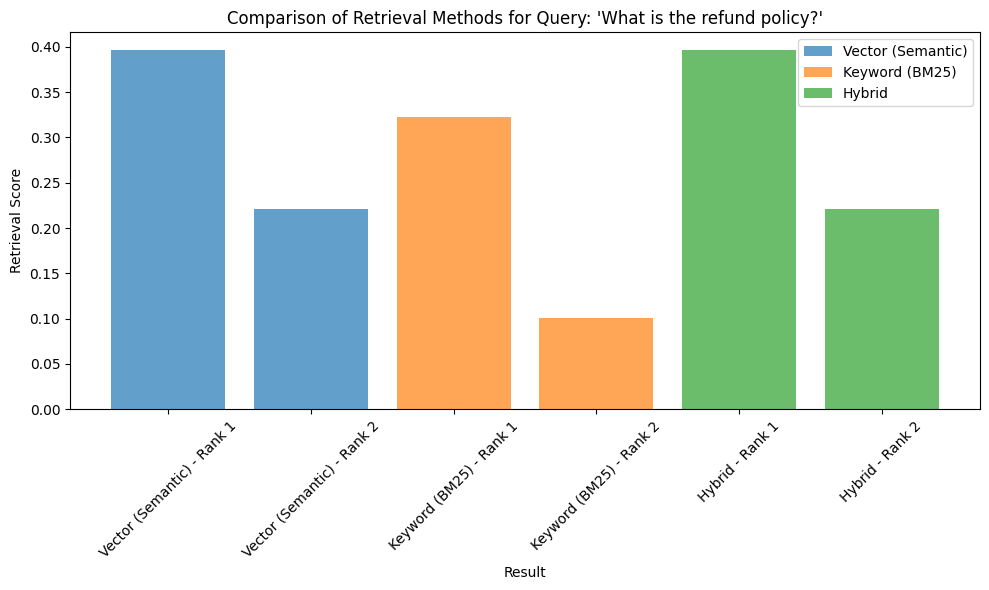

In [ ]:
# Example usage:
comparison = compare_retrieval_methods(index, "What is the refund policy?")

## Section 4: Implement Reranking for More Accurate Results

Reranking helps prioritize the most relevant results after initial retrieval.

## ✅ What it’s doing:

1. Pull a few likely answers first (meaning / semantic-based search):
- It grabs the top 4 passages that seem to match your question by meaning.
- Then it prints that original order so you can see what came back first.

2. Re-score those passages more carefully (re-rank):
- It takes those 4 candidates and has a smarter model read your question + each passage together.
- That model re-scores them for how directly they answer the question and keeps only the best 2.

Analogy:
- A retriever first pulls back several possible text chunks that might answer your question.
- Those chunks are only rough matches, so their order isn’t always the best.
- A reranker model then looks at your question and each chunk together, scores how relevant each chunk really is, and re-orders them.
- The final list has the most relevant passages first, so the LLM builds its answer from the strongest evidence.

3. Show before vs. after: It prints the list again so you can see which passages moved up or down after the careful check.

4. Make a simple comparison table: It builds a small table showing each passage’s rank and score before and after the rerank, plus a short preview of the text.

5. Return the results: It returns that table so you can review or save it.

✅ In short: grab a few good guesses fast, then do a careful read to put the most on-point passages at the top.

In [ ]:
from llama_index.core.postprocessor import SentenceTransformerRerank
from llama_index.core.schema import NodeWithScore

# Create a reranker
def rerank_results(nodes, query, top_n=2):
    """Rerank retrieved nodes using the Sentence Transformer reranker."""
    # Create the reranker
    reranker = SentenceTransformerRerank(
        model="cross-encoder/ms-marco-MiniLM-L-6-v2",
        top_n=top_n
    )

    # Rerank the nodes
    reranked_nodes = reranker.postprocess_nodes(
        nodes,
        query_str=query
    )

    return reranked_nodes

# Function to demonstrate the reranking process
def demonstrate_reranking(index, query, top_k=4):
    """Demonstrate the reranking process on retrieval results."""
    # First retrieve more nodes than we need
    retriever = index.as_retriever(similarity_top_k=top_k)
    nodes = retriever.retrieve(query)

    print(f"Query: {query}")
    print("\nOriginal Retrieval Order:")
    for i, node in enumerate(nodes):
        print(f"{i+1}. (Score: {node.score:.4f}) - {node.get_text()[:100]}...")

    # Now rerank them
    reranked_nodes = rerank_results(nodes, query, top_n=2)

    print("\nAfter Reranking:")
    for i, node in enumerate(reranked_nodes):
        print(f"{i+1}. (Score: {node.score:.4f}) - {node.get_text()[:100]}...")

    # Create comparison dataframe
    results = []

    # Original ranking
    for i, node in enumerate(nodes):
        results.append({
            "Stage": "Original Retrieval",
            "Rank": i + 1,
            "Score": node.score,
            "Content": node.get_text()[:150] + "...",
            "Page": node.metadata.get("page_number", "Unknown")
        })

    # Reranked
    for i, node in enumerate(reranked_nodes):
        results.append({
            "Stage": "After Reranking",
            "Rank": i + 1,
            "Score": node.score,
            "Content": node.get_text()[:150] + "...",
            "Page": node.metadata.get("page_number", "Unknown")
        })

    results_df = pd.DataFrame(results)
    display(results_df)

    return results_df

# Example usage:
reranking_demo = demonstrate_reranking(index, "What happens if I cancel the service?", top_k=4)

Query: What happens if I cancel the service?

Original Retrieval Order:
1. (Score: 0.2854) - SERVICE AGREEMENT CONTRACT
This Service Agreement (the "Agreement") is entered into as of January 15...
2. (Score: 0.1487) - 4.3 No refunds will be issued for completed projects that meet the specifications outlined in Exhibi...


config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]


After Reranking:
1. (Score: -8.6303) - SERVICE AGREEMENT CONTRACT
This Service Agreement (the "Agreement") is entered into as of January 15...
2. (Score: -11.1429) - 4.3 No refunds will be issued for completed projects that meet the specifications outlined in Exhibi...


,Stage,Rank,Score,Content,Page
0,Original Retrieval,1,-8.630345,SERVICE AGREEMENT CONTRACT\nThis Service Agree...,1
1,Original Retrieval,2,-11.142858,4.3 No refunds will be issued for completed pr...,2
2,After Reranking,1,-8.630345,SERVICE AGREEMENT CONTRACT\nThis Service Agree...,1
3,After Reranking,2,-11.142858,4.3 No refunds will be issued for completed pr...,2


## Complete End-to-End Example - Building an Advanced RAG Pipeline

Now let's combine all these techniques into an advanced RAG pipeline:

## ✅ What it’s doing:

1. Count chunks & pick how many to fetch: Checks how many chunks (“nodes”) are in the index and sets a safe top_k (at least 1, at most the number of chunks).

2. Build two searches:
- Meaning-based search: finds chunks that mean the same thing as the question.
- Keyword search (BM25): finds chunks that match the words in the question.

3. Make a hybrid retriever: Runs both searches for a question, merges the results, removes duplicates, and keeps the best top_k.

4. Do a careful re-check (re-rank): Uses a stronger model to read the question + each candidate and re-order them so the most on-point chunks rise to the top (keeps only the best few).

Analogy:
- A retriever first pulls back several possible text chunks that might answer your question.
- Those chunks are only rough matches, so their order isn’t always the best.
- A reranker model then looks at your question and each chunk together, scores how relevant each chunk really is, and re-orders them.
- The final list has the most relevant passages first, so the LLM builds its answer from the strongest evidence.

5. Wrap it into a query engine: Packages the hybrid retriever + reranker with your LLM so you can ask a question and get an answer grounded in the top chunks.

6. Return the engine: You get a ready-to-use RAG pipeline: retrieve (hybrid) → rerank → answer.

In [ ]:
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core.postprocessor import SentenceTransformerRerank
from llama_index.retrievers.bm25 import BM25Retriever
from llama_index.core.retrievers import BaseRetriever
from llama_index.core.schema import NodeWithScore, QueryBundle

def build_rag_pipeline(index):
    """Build a simple but effective RAG pipeline with hybrid retrieval and reranking."""

    # Get all nodes from the index's docstore
    nodes = list(index.docstore.docs.values())

    # Determine safe top_k value (number of nodes to retrieve)
    # Must be at least 1 and no more than the number of available nodes
    num_nodes = len(nodes)
    safe_top_k = min(2, max(1, num_nodes))

    print(f"Index contains {num_nodes} nodes, using top_k={safe_top_k}")

    # Step 1: Create a hybrid retriever combining vector and keyword search
    # First, get the vector retriever (for semantic understanding)
    vector_retriever = index.as_retriever(
        similarity_top_k=safe_top_k  # Retrieve top 3 most similar chunks
    )

    # Next, create a BM25 retriever (for keyword matching)
    # Get all nodes from the index's docstore
    nodes = list(index.docstore.docs.values())
    bm25_retriever = BM25Retriever.from_defaults(
        nodes=nodes,
        similarity_top_k=safe_top_k  # Retrieve top 3 most similar chunks
    )

    # Create a proper hybrid retriever class
    class HybridRetriever(BaseRetriever):
        """Hybrid retriever that combines vector and keyword search results."""

        def __init__(self, vector_retriever, keyword_retriever, top_k=2):
            """Initialize with vector and keyword retrievers."""
            self.vector_retriever = vector_retriever
            self.keyword_retriever = keyword_retriever
            self.top_k = top_k
            super().__init__()

        def _retrieve(self, query_bundle, **kwargs):
            """Retrieve from both retrievers and combine results."""
            # Get results from both retrievers
            vector_nodes = self.vector_retriever.retrieve(query_bundle)
            keyword_nodes = self.keyword_retriever.retrieve(query_bundle)

            # Combine all nodes
            all_nodes = list(vector_nodes) + list(keyword_nodes)

            # Remove duplicates (by node_id)
            unique_nodes = {}
            for node in all_nodes:
                if node.node_id not in unique_nodes:
                    unique_nodes[node.node_id] = node

            # Sort by score (higher is better)
            sorted_nodes = sorted(
                unique_nodes.values(),
                key=lambda x: x.score if hasattr(x, 'score') else 0.0,
                reverse=True
            )

            return sorted_nodes[:self.top_k]  # Return top results

    # Create our hybrid retriever instance
    hybrid_retriever = HybridRetriever(
        vector_retriever=vector_retriever,
        keyword_retriever=bm25_retriever,
        top_k=safe_top_k
    )

    # Step 2: Create a reranker to prioritize the most relevant chunks
    if num_nodes > 1:
        reranker = SentenceTransformerRerank(
            model="cross-encoder/ms-marco-MiniLM-L-6-v2",
            top_n=min(2, num_nodes)  # Keep only top results after reranking
        )
        node_postprocessors = [reranker]
    else:
        node_postprocessors = []


    # Step 3: Build the query engine
    query_engine = RetrieverQueryEngine.from_args(
        retriever=hybrid_retriever,
        llm=llm,
        node_postprocessors=[reranker]
    )

    return query_engine

In [ ]:
# Example usage:
# pdf_path = upload_pdf()
index = process_and_index_pdf(pdf_path)
rag_engine = build_rag_pipeline(index)
response = rag_engine.query("What are the penalties for late payments?")
print('\nFinal Response:\n ---------------------- \n')
print(response)

Processed sample_docs/sample_contract.pdf:
Extracted 2 pages with content


DEBUG:bm25s:Building index from IDs objects


Indexed 2 document chunks
Index contains 2 nodes, using top_k=2

Final Response:
 ---------------------- 

Late payments will accrue interest at a rate of 1.5% per month from the due date until the payment is complete.



### Why This Approach Works Well

1. **Hybrid Retrieval**: By combining vector search (semantic understanding) with BM25 (keyword matching), we get the best of both worlds:
   - Vector search finds semantically related content even if keywords don't match
   - BM25 ensures we don't miss exact term matches that might be relevant

2. **Reranking**: The SentenceTransformer reranker provides a second opinion on relevance:
   - It uses a specialized cross-encoder model to score query-chunk pairs
   - This helps filter out chunks that might be tangentially related but not directly relevant
   - Results in higher precision answers with less noise

3. **Simplicity**: This approach avoids complex routing logic while still delivering high-quality results:
   - No need for multiple specialized retrievers with complex selection logic
   - Handles most query types well without additional complexity
   - Easier to maintain and understand

This pipeline will retrieve relevant information from PDFs and generate concise, accurate responses using Gemini's capabilities.

## Conclusion

In this notebook, we explored advanced PDF retrieval techniques with LlamaIndex:

1. Loading and processing PDFs using PyMuPDF
2. Implementing query expansion to improve retrieval quality
3. Using hybrid retrieval to combine semantic and keyword search
4. Applying reranking to prioritize the most relevant results
5. Building an advanced RAG pipeline that combines all these techniques

These techniques can significantly improve the quality of information retrieval from PDFs and other document types in real-world applications.

## Experiments of RAG pipeline optimization (Sriram's written code)

Exp 1: Changing cross-encoder from Mini-LM-L-6-V2 to Mini-LM-L-12-V2

In [ ]:
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core.postprocessor import SentenceTransformerRerank
from llama_index.retrievers.bm25 import BM25Retriever
from llama_index.core.retrievers import BaseRetriever
from llama_index.core.schema import NodeWithScore, QueryBundle

def build_rag_pipeline(index):
    """Build a simple but effective RAG pipeline with hybrid retrieval and reranking."""

    # Get all nodes from the index's docstore
    nodes = list(index.docstore.docs.values())

    # Determine safe top_k value (number of nodes to retrieve)
    # Must be at least 1 and no more than the number of available nodes
    num_nodes = len(nodes)
    safe_top_k = min(2, max(1, num_nodes))

    print(f"Index contains {num_nodes} nodes, using top_k={safe_top_k}")

    # Step 1: Create a hybrid retriever combining vector and keyword search
    # First, get the vector retriever (for semantic understanding)
    vector_retriever = index.as_retriever(
        similarity_top_k=safe_top_k  # Retrieve top 3 most similar chunks
    )

    # Next, create a BM25 retriever (for keyword matching)
    # Get all nodes from the index's docstore
    nodes = list(index.docstore.docs.values())
    bm25_retriever = BM25Retriever.from_defaults(
        nodes=nodes,
        similarity_top_k=safe_top_k  # Retrieve top 3 most similar chunks
    )

    # Create a proper hybrid retriever class
    class HybridRetriever(BaseRetriever):
        """Hybrid retriever that combines vector and keyword search results."""

        def __init__(self, vector_retriever, keyword_retriever, top_k=2):
            """Initialize with vector and keyword retrievers."""
            self.vector_retriever = vector_retriever
            self.keyword_retriever = keyword_retriever
            self.top_k = top_k
            super().__init__()

        def _retrieve(self, query_bundle, **kwargs):
            """Retrieve from both retrievers and combine results."""
            # Get results from both retrievers
            vector_nodes = self.vector_retriever.retrieve(query_bundle)
            keyword_nodes = self.keyword_retriever.retrieve(query_bundle)

            # Combine all nodes
            all_nodes = list(vector_nodes) + list(keyword_nodes)

            # Remove duplicates (by node_id)
            unique_nodes = {}
            for node in all_nodes:
                if node.node_id not in unique_nodes:
                    unique_nodes[node.node_id] = node

            # Sort by score (higher is better)
            sorted_nodes = sorted(
                unique_nodes.values(),
                key=lambda x: x.score if hasattr(x, 'score') else 0.0,
                reverse=True
            )

            return sorted_nodes[:self.top_k]  # Return top results

    # Create our hybrid retriever instance
    hybrid_retriever = HybridRetriever(
        vector_retriever=vector_retriever,
        keyword_retriever=bm25_retriever,
        top_k=safe_top_k
    )

    # Step 2: Create a reranker to prioritize the most relevant chunks
    if num_nodes > 1:
        reranker = SentenceTransformerRerank(
            model="cross-encoder/ms-marco-MiniLM-L-12-v2",
            top_n=min(2, num_nodes)  # Keep only top results after reranking
        )
        node_postprocessors = [reranker]
    else:
        node_postprocessors = []


    # Step 3: Build the query engine
    query_engine = RetrieverQueryEngine.from_args(
        retriever=hybrid_retriever,
        llm=llm,
        node_postprocessors=[reranker]
    )

    return query_engine

In [ ]:
# Example usage:
# pdf_path = upload_pdf()
index = process_and_index_pdf(pdf_path)
rag_engine = build_rag_pipeline(index)
response = rag_engine.query("What are the penalties for late payments?")
print('\nFinal Response:\n ---------------------- \n')
print(response)

Processed sample_docs/sample_contract.pdf:
Extracted 2 pages with content


DEBUG:bm25s:Building index from IDs objects


Indexed 2 document chunks
Index contains 2 nodes, using top_k=2


config.json:   0%|          | 0.00/791 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]


Final Response:
 ---------------------- 

Late payments will accrue interest at a rate of 1.5% per month from the due date until the payment is complete.



Exp 2: Changing cross-encoder from Mini-LM-L-6-V2 to electra-base

In [ ]:
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core.postprocessor import SentenceTransformerRerank
from llama_index.retrievers.bm25 import BM25Retriever
from llama_index.core.retrievers import BaseRetriever
from llama_index.core.schema import NodeWithScore, QueryBundle

def build_rag_pipeline(index):
    """Build a simple but effective RAG pipeline with hybrid retrieval and reranking."""

    # Get all nodes from the index's docstore
    nodes = list(index.docstore.docs.values())

    # Determine safe top_k value (number of nodes to retrieve)
    # Must be at least 1 and no more than the number of available nodes
    num_nodes = len(nodes)
    safe_top_k = min(2, max(1, num_nodes))

    print(f"Index contains {num_nodes} nodes, using top_k={safe_top_k}")

    # Step 1: Create a hybrid retriever combining vector and keyword search
    # First, get the vector retriever (for semantic understanding)
    vector_retriever = index.as_retriever(
        similarity_top_k=safe_top_k  # Retrieve top 3 most similar chunks
    )

    # Next, create a BM25 retriever (for keyword matching)
    # Get all nodes from the index's docstore
    nodes = list(index.docstore.docs.values())
    bm25_retriever = BM25Retriever.from_defaults(
        nodes=nodes,
        similarity_top_k=safe_top_k  # Retrieve top 3 most similar chunks
    )

    # Create a proper hybrid retriever class
    class HybridRetriever(BaseRetriever):
        """Hybrid retriever that combines vector and keyword search results."""

        def __init__(self, vector_retriever, keyword_retriever, top_k=2):
            """Initialize with vector and keyword retrievers."""
            self.vector_retriever = vector_retriever
            self.keyword_retriever = keyword_retriever
            self.top_k = top_k
            super().__init__()

        def _retrieve(self, query_bundle, **kwargs):
            """Retrieve from both retrievers and combine results."""
            # Get results from both retrievers
            vector_nodes = self.vector_retriever.retrieve(query_bundle)
            keyword_nodes = self.keyword_retriever.retrieve(query_bundle)

            # Combine all nodes
            all_nodes = list(vector_nodes) + list(keyword_nodes)

            # Remove duplicates (by node_id)
            unique_nodes = {}
            for node in all_nodes:
                if node.node_id not in unique_nodes:
                    unique_nodes[node.node_id] = node

            # Sort by score (higher is better)
            sorted_nodes = sorted(
                unique_nodes.values(),
                key=lambda x: x.score if hasattr(x, 'score') else 0.0,
                reverse=True
            )

            return sorted_nodes[:self.top_k]  # Return top results

    # Create our hybrid retriever instance
    hybrid_retriever = HybridRetriever(
        vector_retriever=vector_retriever,
        keyword_retriever=bm25_retriever,
        top_k=safe_top_k
    )

    # Step 2: Create a reranker to prioritize the most relevant chunks
    if num_nodes > 1:
        reranker = SentenceTransformerRerank(
            model="cross-encoder/ms-marco-electra-base",
            top_n=min(2, num_nodes)  # Keep only top results after reranking
        )
        node_postprocessors = [reranker]
    else:
        node_postprocessors = []


    # Step 3: Build the query engine
    query_engine = RetrieverQueryEngine.from_args(
        retriever=hybrid_retriever,
        llm=llm,
        node_postprocessors=[reranker]
    )

    return query_engine

In [ ]:
# Example usage:
# pdf_path = upload_pdf()
index = process_and_index_pdf(pdf_path)
rag_engine = build_rag_pipeline(index)
response = rag_engine.query("What are the penalties for late payments?")
print('\nFinal Response:\n ---------------------- \n')
print(response)

Processed sample_docs/sample_contract.pdf:
Extracted 2 pages with content


DEBUG:bm25s:Building index from IDs objects


Indexed 2 document chunks
Index contains 2 nodes, using top_k=2


config.json:   0%|          | 0.00/730 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]


Final Response:
 ---------------------- 

Late payments will accrue interest at a rate of 1.5% per month from the due date until the payment is made in full.



Exp 3: Testing using other queries and cross-encoder models with config: MiniLM-L-12-v2

In [ ]:
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core.postprocessor import SentenceTransformerRerank
from llama_index.retrievers.bm25 import BM25Retriever
from llama_index.core.retrievers import BaseRetriever
from llama_index.core.schema import NodeWithScore, QueryBundle

def build_rag_pipeline(index):
    """Build a simple but effective RAG pipeline with hybrid retrieval and reranking."""

    # Get all nodes from the index's docstore
    nodes = list(index.docstore.docs.values())

    # Determine safe top_k value
    num_nodes = len(nodes)
    safe_top_k = min(2, max(1, num_nodes))
    print(f"Index contains {num_nodes} nodes, using top_k={safe_top_k}")

    # Step 1: Hybrid retriever (vector + BM25)
    vector_retriever = index.as_retriever(similarity_top_k=safe_top_k)

    nodes = list(index.docstore.docs.values())
    bm25_retriever = BM25Retriever.from_defaults(
        nodes=nodes,
        similarity_top_k=safe_top_k
    )

    class HybridRetriever(BaseRetriever):
        """Hybrid retriever that combines vector and keyword search results."""
        def __init__(self, vector_retriever, keyword_retriever, top_k=2):
            self.vector_retriever = vector_retriever
            self.keyword_retriever = keyword_retriever
            self.top_k = top_k
            super().__init__()

        def _retrieve(self, query_bundle, **kwargs):
            vector_nodes = self.vector_retriever.retrieve(query_bundle)
            keyword_nodes = self.keyword_retriever.retrieve(query_bundle)
            all_nodes = list(vector_nodes) + list(keyword_nodes)

            # Dedup by node_id
            unique_nodes = {}
            for node in all_nodes:
                if node.node_id not in unique_nodes:
                    unique_nodes[node.node_id] = node

            # Sort by score desc
            sorted_nodes = sorted(
                unique_nodes.values(),
                key=lambda x: x.score if hasattr(x, 'score') else 0.0,
                reverse=True
            )
            return sorted_nodes[:self.top_k]

    hybrid_retriever = HybridRetriever(
        vector_retriever=vector_retriever,
        keyword_retriever=bm25_retriever,
        top_k=safe_top_k
    )

    # Step 2: Reranker (optional if only 1 node)
    if num_nodes > 1:
        reranker = SentenceTransformerRerank(
            model="cross-encoder/ms-marco-MiniLM-L-12-v2",
            top_n=min(2, num_nodes)
        )
        node_postprocessors = [reranker]
    else:
        node_postprocessors = []

    # Step 3: Query engine (⚠️ pass the list, not an undefined variable)
    query_engine = RetrieverQueryEngine.from_args(
        retriever=hybrid_retriever,
        llm=llm,
        node_postprocessors=node_postprocessors
    )

    return query_engine

In [ ]:
# --- Example usage: run multiple queries ---
# index = process_and_index_pdf(pdf_path)
rag_engine = build_rag_pipeline(index)

queries = [
    "What are the penalties for late payments?",
    "What are the payment terms?",
    "What is the termination notice period?",
    "When does the agreement become effective?",
    "What is the refund window?"
]

for q in queries:
    resp = rag_engine.query(q)
    print("\nFinal Response:\n----------------------")
    print(f"Q: {q}\n")
    print(resp.response)

    # Print sources (best-effort across possible node shapes)
    print("\nSources:")
    for i, sn in enumerate(resp.source_nodes, start=1):
        try:
            text = sn.get_text()
        except Exception:
            text = getattr(sn, "text", None)
            if text is None and hasattr(sn, "node"):
                text = sn.node.get_text()
        score = getattr(sn, "score", 0.0)
        preview = (text or "")[:200].replace("\n", " ")
        print(f"[{i}] (score={score:.4f}) {preview}...")

DEBUG:bm25s:Building index from IDs objects


Index contains 2 nodes, using top_k=2

Final Response:
----------------------
Q: What are the penalties for late payments?

Late payments will accrue interest at a rate of 1.5% per month from the due date until the payment is complete.


Sources:
[1] (score=-7.4319) SERVICE AGREEMENT CONTRACT This Service Agreement (the "Agreement") is entered into as of January 15, 2025 (the "Effective Date") by and between: ABC Company Inc., with its principal place of business...
[2] (score=-11.1689) 4.3 No refunds will be issued for completed projects that meet the specifications outlined in Exhibit A. 5. CONFIDENTIALITY 5.1 Each party acknowledges that it may receive confidential information fro...

Final Response:
----------------------
Q: What are the payment terms?

The client will pay the service provider based on rates detailed in a separate document.  Invoices are issued monthly, and payment is due within 30 days of receipt.  Late payments accrue a 1.5% monthly interest charge.


Sources:
[1